In this notebook we inspect different candidates for housekeeping genes by using literature and seacthing for genes that have a lower standard deviation.

In [1]:
import sys
!git clone https://github.com/Ignas12345/masters_project_helper_functions.git
sys.path.append('/content/masters_project_helper_functions')

Cloning into 'masters_project_helper_functions'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 4), reused 14 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 6.20 KiB | 6.20 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
import pandas as pd
import numpy as np
import masters_project_helper_functions.plotting as plotting
import masters_project_helper_functions.utils as utils
import masters_project_helper_functions.filtering_and_scaling as fs

In [3]:
url_TCGA_TGCT_mirna_raw_counts = "https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/expression_values/TCGA_TGCT_mirna_isoform_data_raw_counts.csv"
TCGA_TGCT_mirna_raw_counts = pd.read_csv(url_TCGA_TGCT_mirna_raw_counts, index_col=0, sep = ';').T
TCGA_TGCT_mirna_raw_counts.index = TCGA_TGCT_mirna_raw_counts.index.str[:15]
url_TCGA_TGCT_mirna_rpm = "https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/expression_values/TCGA_TGCT_mirna_isoform_data_rpm.csv"
TCGA_TGCT_mirna_rpm = pd.read_csv(url_TCGA_TGCT_mirna_rpm, index_col=0, sep=';', decimal=',').T
TCGA_TGCT_mirna_rpm.index = TCGA_TGCT_mirna_rpm.index.str[:15]
# Convert all columns to numeric, coercing errors to NaN
#TCGA_TGCT_mirna_rpm = TCGA_TGCT_mirna_rpm.apply(pd.to_numeric, errors='coerce')
TCGA_TGCT_divisions_by_experiment_url = "https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/sample_annotations/TCGA_TGCT_divisions_by_experiment.csv"
TCGA_TGCT_divisions_by_experiment = pd.read_csv(TCGA_TGCT_divisions_by_experiment_url, index_col=0)

Searching for a candidate from raw counts data is probably less advisable, as that does not account for sequencing depth (later we will use raw counts from a candidate houskeeping gene for normalization, but to find that candidate it is better to use RPM values).

In [4]:
#Firstly we pre-process the rpm matrix
df_to_use = TCGA_TGCT_mirna_rpm.copy()
df_to_use.fillna(0, inplace=True)
df_to_use_collapsed = utils.collapse_columns_by_string(df_to_use)
df_to_use_filtered = utils.filter_by_suffix(df_to_use_collapsed, suffix_to_not_include = ('unannotated', 'precursor', 'stemloop'))
#leave only the first 15 characters of index
df_to_use_filtered.index = df_to_use_filtered.index.str[:15]
df_to_use_filtered = df_to_use_filtered.loc[TCGA_TGCT_divisions_by_experiment.index].copy()
print("shape after filtering according to samples" + str(df_to_use_filtered.shape))

initial shape: (156, 3689)
shape after collapsing: (156, 2212)
initial shape: (156, 2212)
shape after filtering: (156, 2191)
shape after filtering according to samples(137, 2191)


In [5]:
#This is to calculate the relative variance of each feature (ChatGPT's function)
df_for_stability_analysis = df_to_use_filtered.copy()
#df_for_stability_analysis = np.log2(df_for_stability_analysis + 1)  # Log-transform if needed
#flter features with stds. that are smaller than 1:
#df_for_stability_analysis = df_for_stability_analysis.loc[:, df_for_stability_analysis.std() > 5]
# Calculate coefficient of variation per miRNA
cv = df_for_stability_analysis.std(axis=0) / df_for_stability_analysis.mean(axis=0)

# Rank by stability (lower CV = more stable)
stable_mirnas = cv.sort_values()
stable_mirnas.head(20)

,0
"hsa-mir-148b, mature,MIMAT0000759",0.265069
"hsa-mir-22, mature,MIMAT0000077",0.282538
"hsa-mir-30e, mature,MIMAT0000692",0.308709
"hsa-mir-23a, mature,MIMAT0000078",0.314990
"hsa-mir-26a-1, mature,MIMAT0000082",0.318338
"hsa-mir-186, mature,MIMAT0000456",0.321743
"hsa-mir-16-1, mature,MIMAT0000069",0.358768
"hsa-mir-27a, mature,MIMAT0000084",0.369186
"hsa-mir-30d, mature,MIMAT0004551",0.372659
"hsa-mir-374a, mature,MIMAT0000727",0.373656


Below is a list of candidate houskeeping miRNAs from the literature. miR 16-5p (hsa-mir-16-1, mature,MIMAT0000069) is a popular choice. It is taken together with miR-29a-3p often. Other popular choices include hsa-mir-93. Some studies have found that miR-520d-5p is a good serum houskeeping gene, but it appears that in our case of tissue expression, it is less stable.

In [69]:
#Small function find in index of df_to use all features that start with: 'hsa-mir-x'
df_to_use_filtered.columns[df_to_use_filtered.columns.str.startswith('hsa-mir-371a')]

Index(['hsa-mir-371a, mature,MIMAT0000723', 'hsa-mir-371a, mature,MIMAT0004687'], dtype='object')

In [6]:
list_of_candidate_housekeeping_genes = ['hsa-mir-520d, mature,MIMAT0002855',
                                        'hsa-mir-520d, mature,MIMAT0002856',
                                        'hsa-mir-16-1, mature,MIMAT0000069',
                                        'hsa-mir-16-1, mature,MIMAT0004489',
                                        'hsa-mir-25, mature,MIMAT0000081',
                                        'hsa-mir-25, mature,MIMAT0004498',
                                        'hsa-mir-29a, mature,MIMAT0000086',
                                        'hsa-mir-29a, mature,MIMAT0004503',
                                        'hsa-mir-93, mature,MIMAT0000093',
                                        'hsa-mir-93, mature,MIMAT0004509',
                                        'hsa-mir-191, mature,MIMAT0000440',
                                        'hsa-mir-191, mature,MIMAT0001618',
                                        'hsa-mir-222, mature,MIMAT0000279',
                                        'hsa-mir-222, mature,MIMAT0004569',
                                        ]

In [7]:
stable_mirnas.loc[list_of_candidate_housekeeping_genes].sort_values()

,0
"hsa-mir-16-1, mature,MIMAT0000069",0.358768
"hsa-mir-191, mature,MIMAT0000440",0.397003
"hsa-mir-16-1, mature,MIMAT0004489",0.440347
"hsa-mir-222, mature,MIMAT0000279",0.471595
"hsa-mir-29a, mature,MIMAT0004503",0.541288
"hsa-mir-93, mature,MIMAT0004509",0.573434
"hsa-mir-93, mature,MIMAT0000093",0.605639
"hsa-mir-25, mature,MIMAT0000081",0.626323
"hsa-mir-29a, mature,MIMAT0000086",0.657399
"hsa-mir-222, mature,MIMAT0004569",0.729133


Plots of the top ranked "stable mirnas".

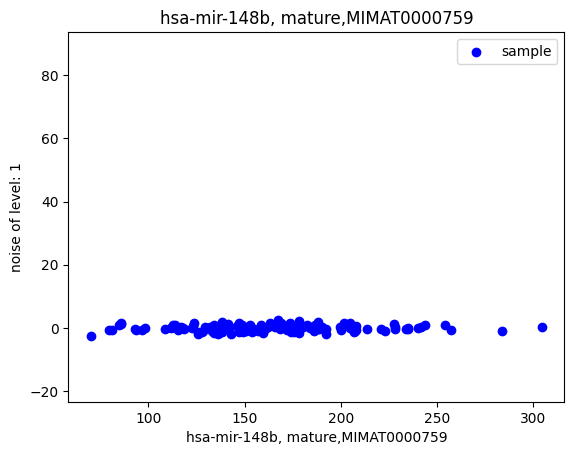

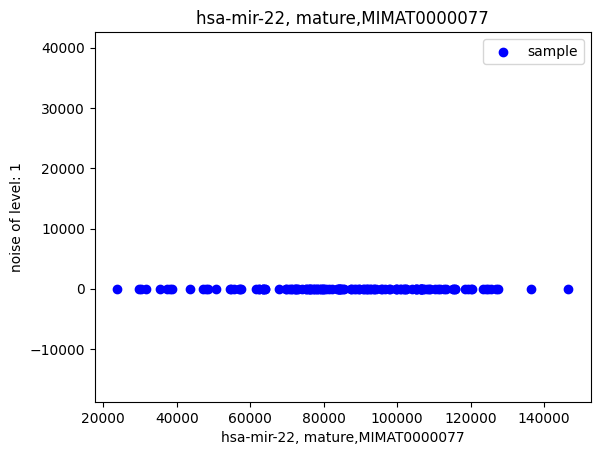

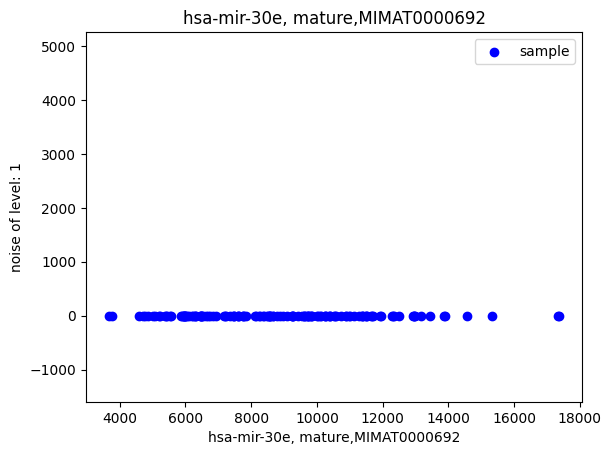

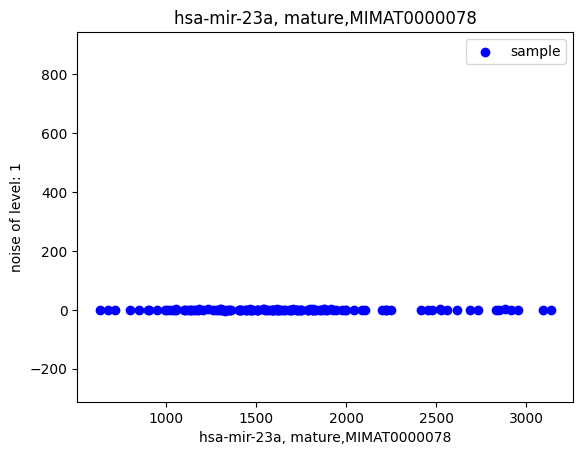

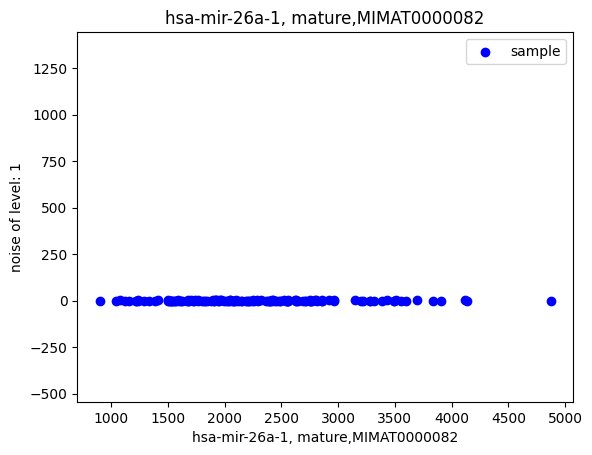

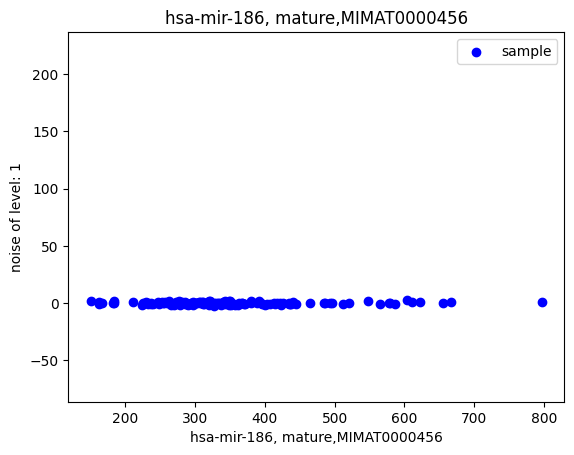

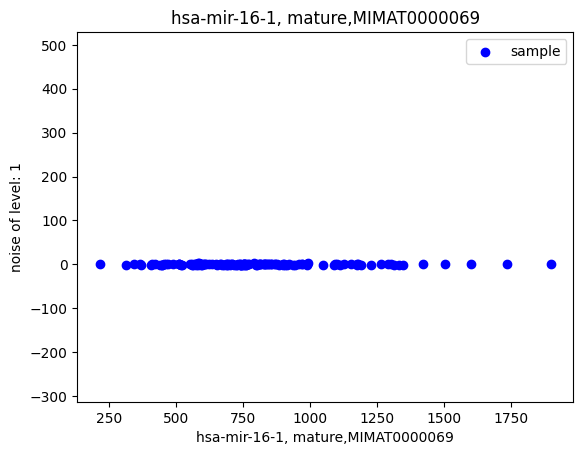

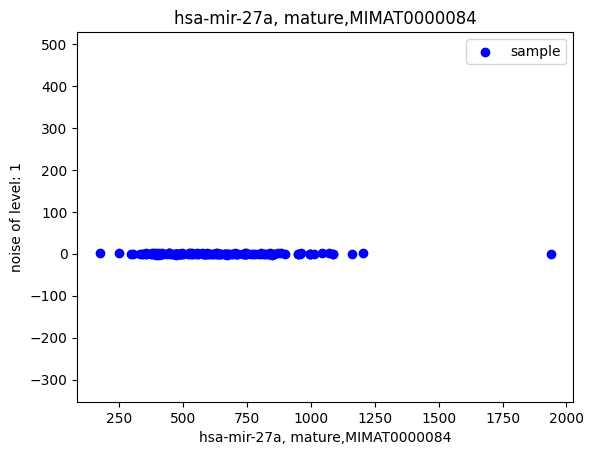

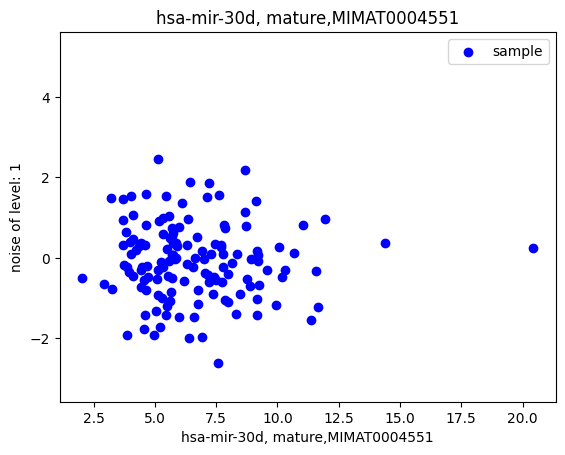

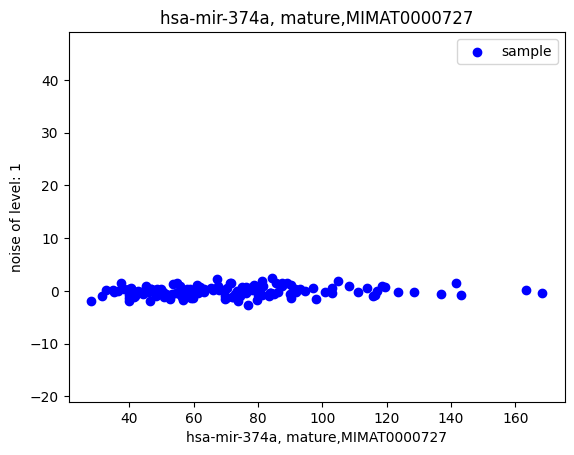

In [8]:
for mirna in list(stable_mirnas.head(10).index):
  plotting.plot_single_feature(df_to_use_filtered, mirna, noise_level=1, title= mirna)


Plots of the candidate mirnas. Notice that for example miR-520d is not expressed for some samples which makes it impossible to use for normalization

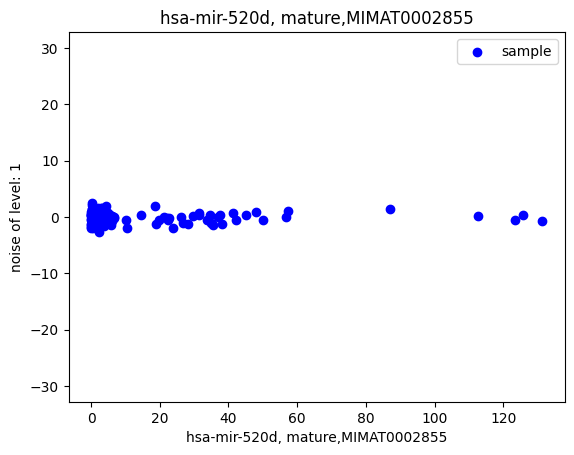

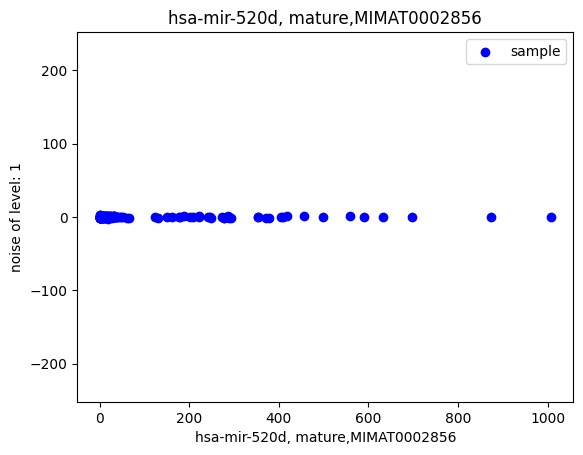

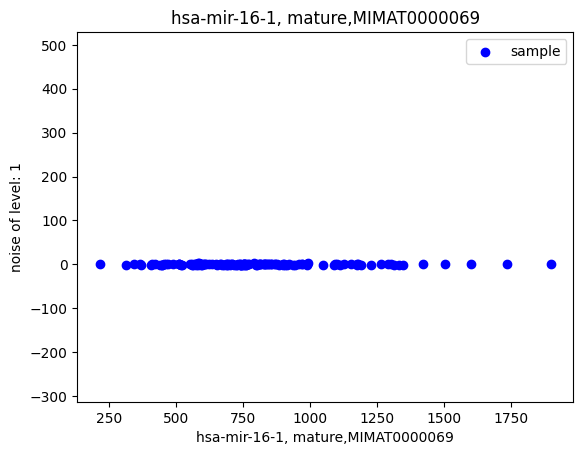

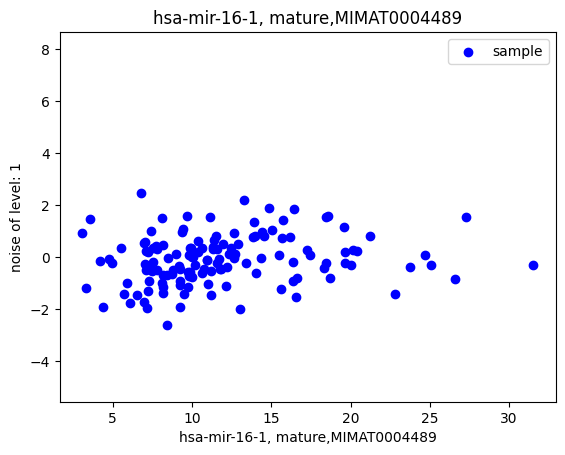

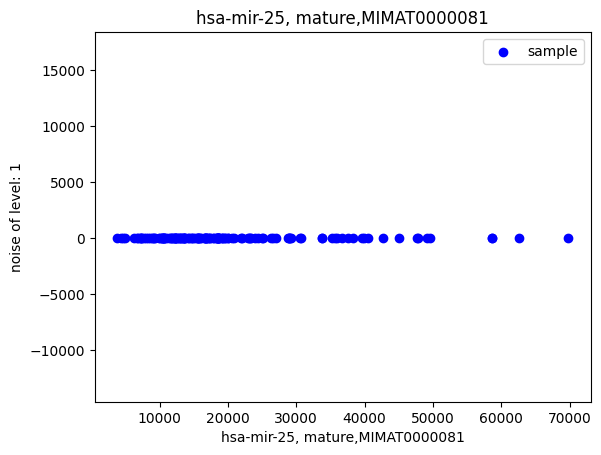

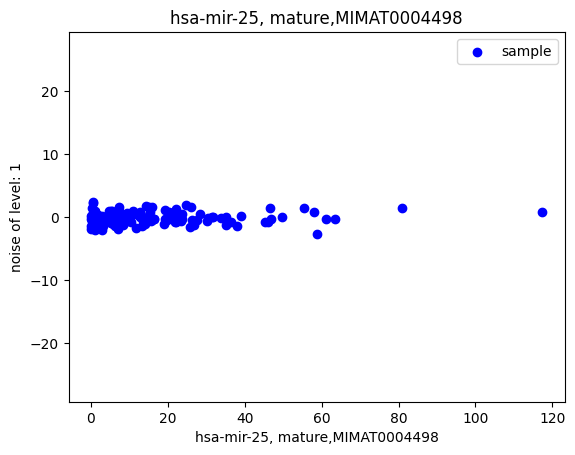

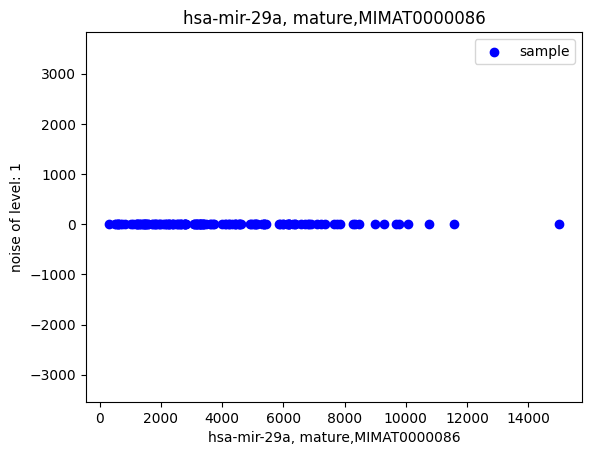

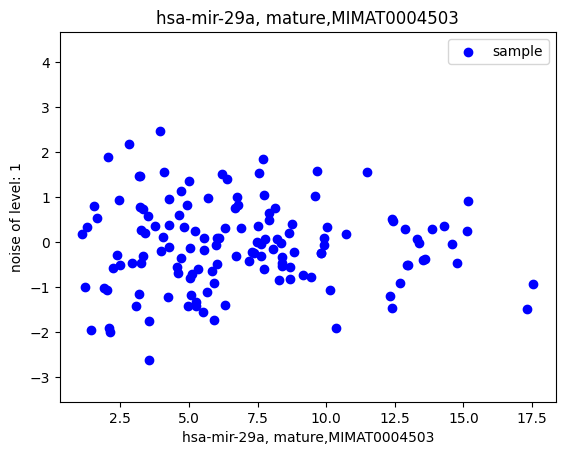

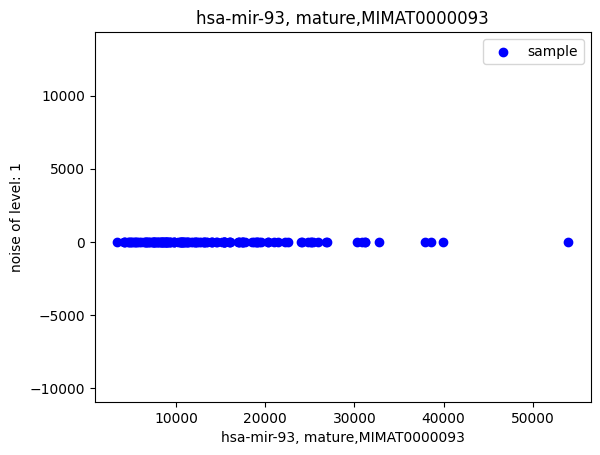

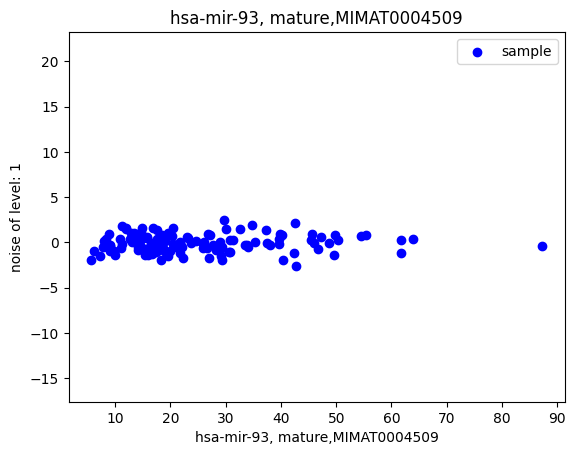

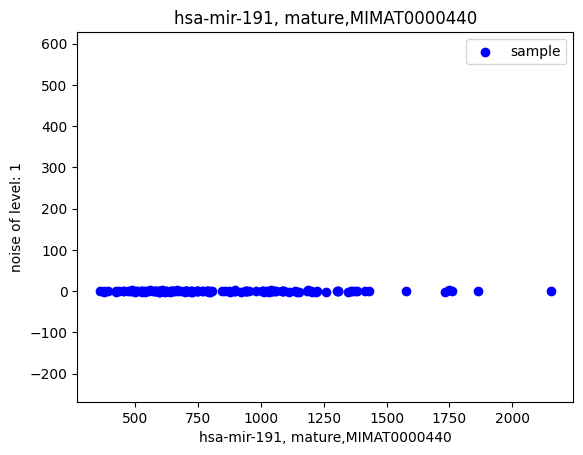

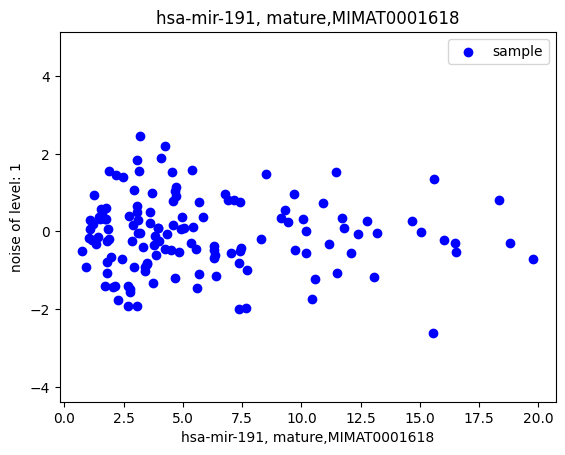

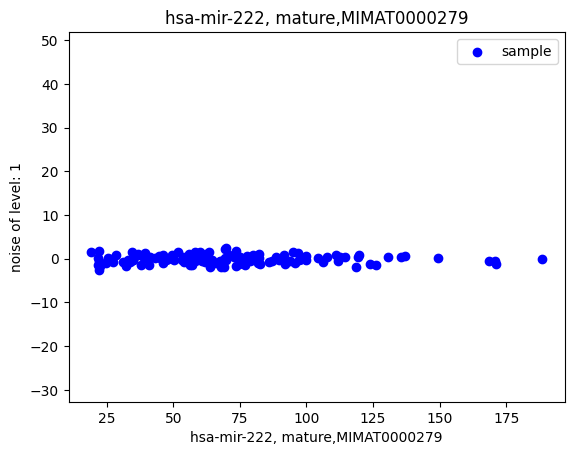

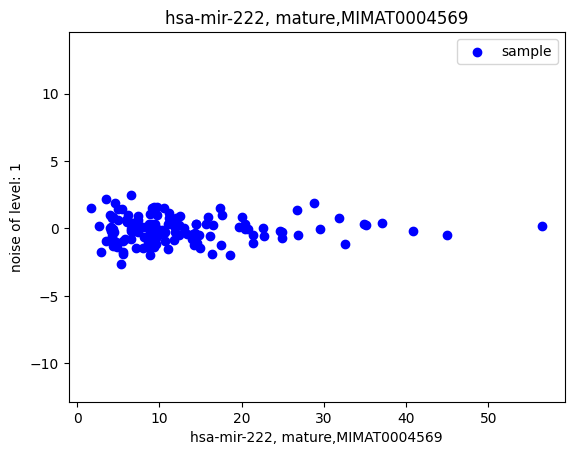

In [9]:
for mirna in list_of_candidate_housekeeping_genes:
  plotting.plot_single_feature(df_to_use_filtered, mirna, noise_level=1, title= mirna)

In [11]:
def normalize_by_housekeeping_list(df, housekeeping_mirnas: list, method="ratio", log_transform=False, factor = None):
    """
    Written by ChatGPT
    Normalize miRNA expression data by housekeeping gene(s).
    Assumes:
    - Rows = samples
    - Columns = miRNAs

    Parameters:
    - df: pandas DataFrame (rows = samples, columns = miRNAs), raw counts
    - housekeeping_mirnas: list of miRNA names (column names) to use as reference
    - method: "ratio" (x / hk) or "delta_log2" (log2(x+1) - log2(hk+1))
    - log_transform: whether to log2-transform result (only used with "ratio")

    Returns:
    - normalized_df: pandas DataFrame of normalized expression values
    """
    # Check that all HK miRNAs exist in columns
    missing = [mir for mir in housekeeping_mirnas if mir not in df.columns]
    if missing:
        raise ValueError(f"Missing housekeeping miRNAs in input data: {missing}")

    # Reference = mean expression of housekeeping miRNA(s) for each sample
    hk_expr = df[housekeeping_mirnas]
    if len(housekeeping_mirnas) > 1:
        reference = hk_expr.mean(axis=1)
    else:
        reference = hk_expr.iloc[:, 0]
    if factor is None:
      factor = 1
    # Method 1: ratio
    if method == "ratio":
        normalized_df = df.div(reference, axis=0)
        if log_transform:
            normalized_df = np.log2(normalized_df + 1)

    # Method 2: delta_log2
    elif method == "delta_log2":
        log_df = np.log2(df + 1)
        log_ref = np.log2(reference + 1)
        normalized_df = log_df.subtract(log_ref, axis=0)

    else:
        raise ValueError("Invalid method. Use 'ratio' or 'delta_log2'.")

    return normalized_df

In [66]:
experiment_names = TCGA_TGCT_divisions_by_experiment.keys()
experiment_names

Index(['seminoma_vs_non_seminoma', 'seminoma_vs_embryonal',
       'embryonal_vs_non_embryonal_non_seminoma', 'teratoma_vs_non_teratoma',
       'KIT_wildtype_vs_mutated_seminoma',
       'teratoma_present_vs_teratoma_absent'],
      dtype='object')

Now, to actually perform normalization, we have to switch to raw counts

In [12]:
df_to_use = TCGA_TGCT_mirna_raw_counts.copy()
df_to_use.fillna(0, inplace=True)
df_to_use_collapsed = utils.collapse_columns_by_string(df_to_use)
df_to_use_filtered = utils.filter_by_suffix(df_to_use_collapsed, suffix_to_not_include = ('unannotated', 'precursor', 'stemloop'))
#leave only the first 15 characters of index
df_to_use_filtered.index = df_to_use_filtered.index.str[:15]
df_to_use_filtered = df_to_use_filtered.loc[TCGA_TGCT_divisions_by_experiment.index].copy()
print("shape after filtering according to samples" + str(df_to_use_filtered.shape))

initial shape: (156, 3689)
shape after collapsing: (156, 2212)
initial shape: (156, 2212)
shape after filtering: (156, 2191)
shape after filtering according to samples(137, 2191)


We know that 371a-3p is good at discriminating teratomas vs. non_teratomas - we want to see if this property is preserved if we scale everything by our houskeeping gene.

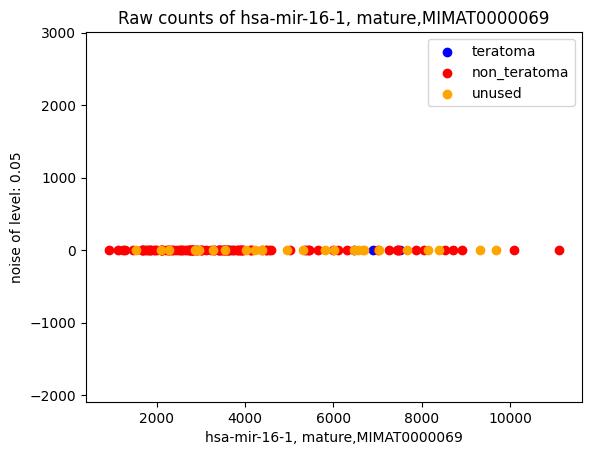

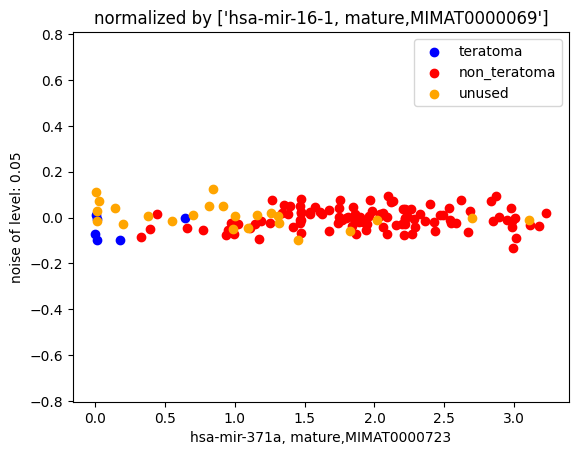

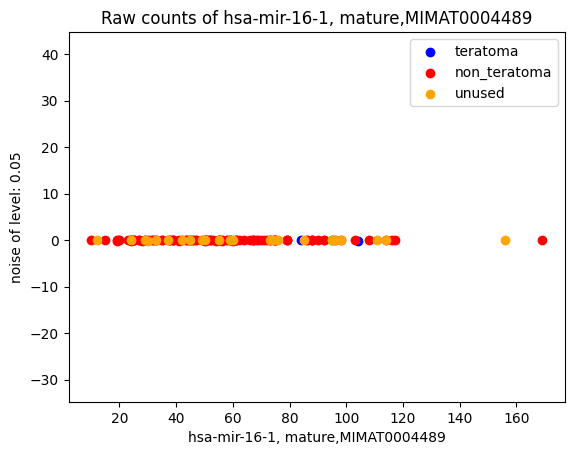

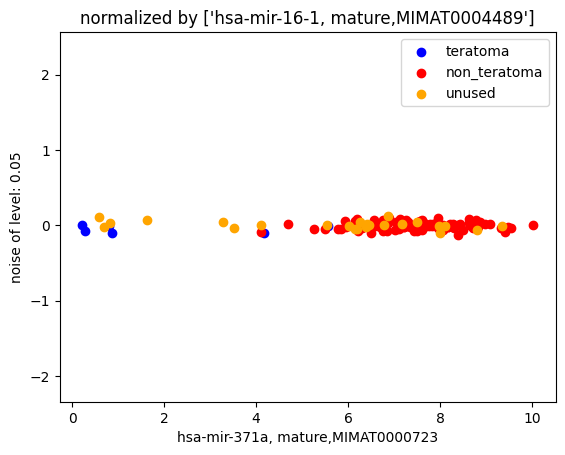

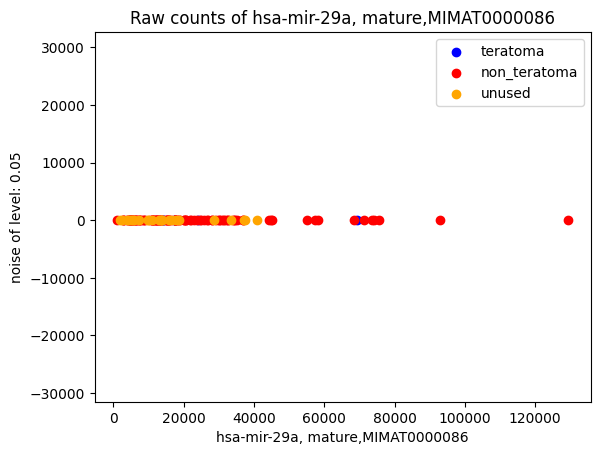

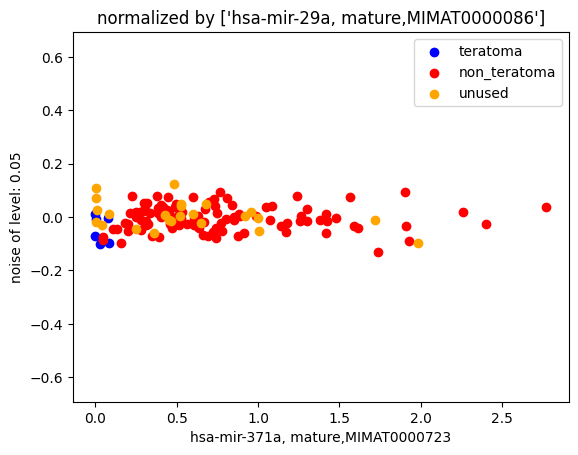

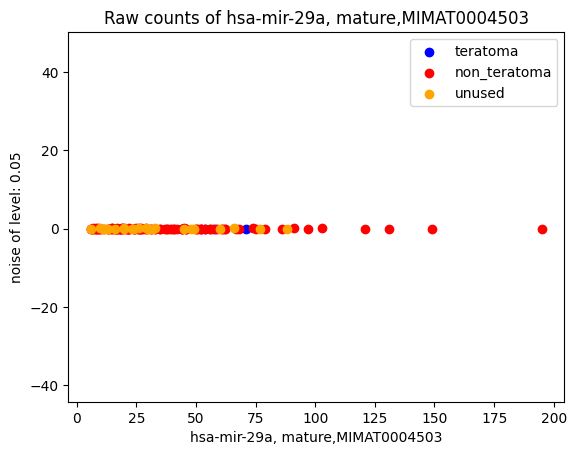

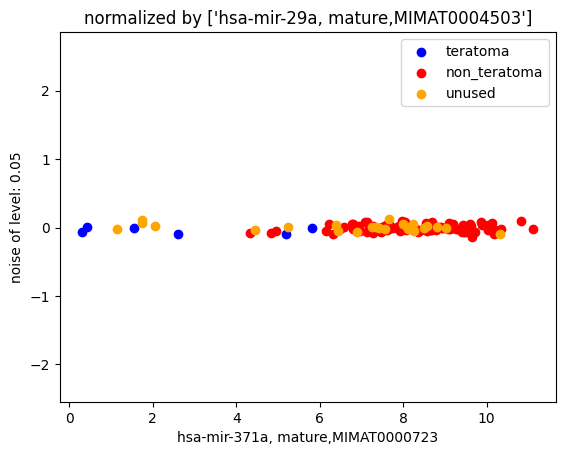

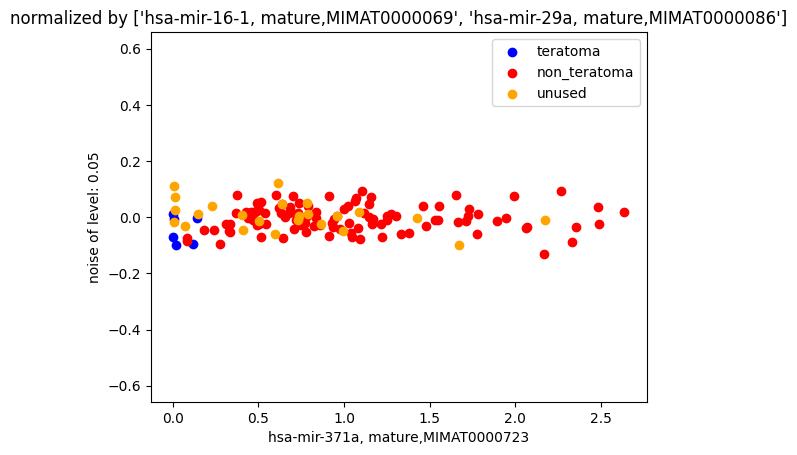

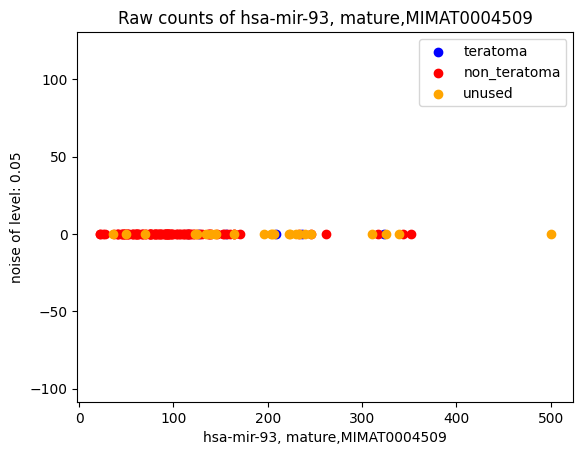

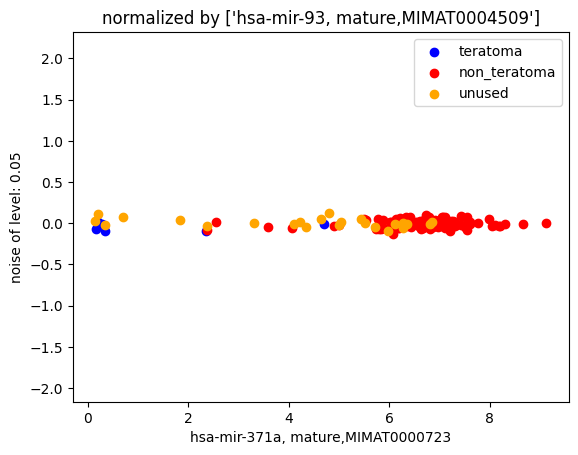

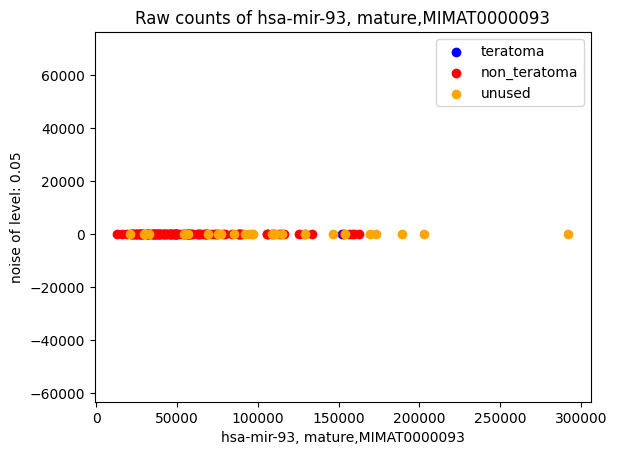

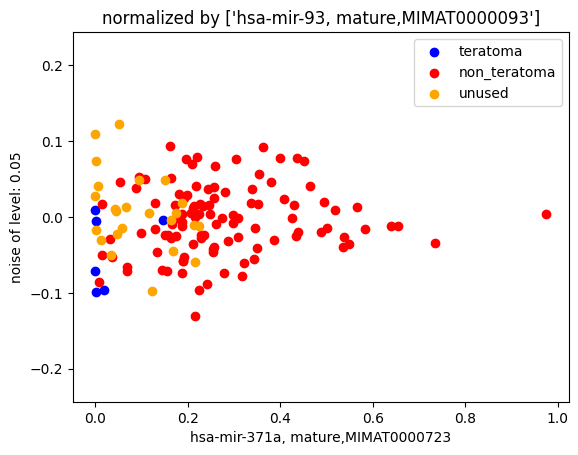

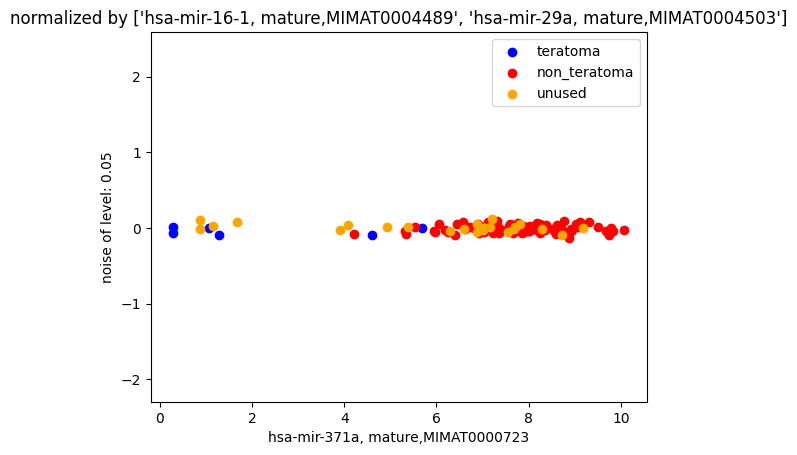

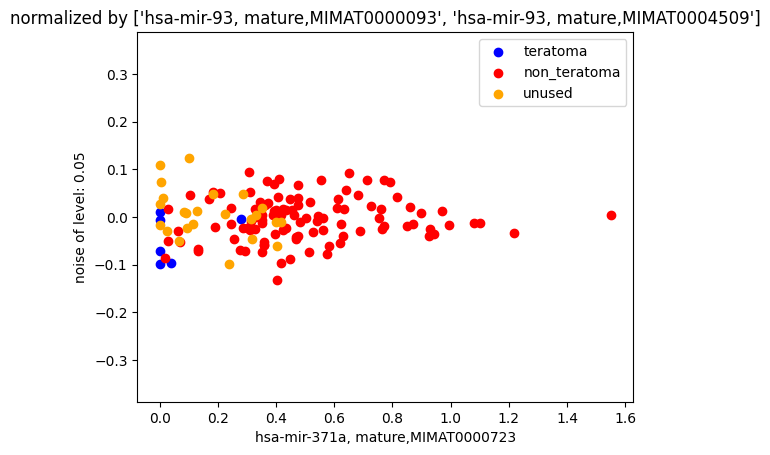

In [14]:
#possible lists of houskeeping genes to use for normalization
houskeeping_lists = [['hsa-mir-16-1, mature,MIMAT0000069',], ['hsa-mir-16-1, mature,MIMAT0004489',],
                     ['hsa-mir-29a, mature,MIMAT0000086',], ['hsa-mir-29a, mature,MIMAT0004503',] ,
                    ['hsa-mir-16-1, mature,MIMAT0000069', 'hsa-mir-29a, mature,MIMAT0000086',],
                     ['hsa-mir-93, mature,MIMAT0004509',], ['hsa-mir-93, mature,MIMAT0000093'],
                     ['hsa-mir-16-1, mature,MIMAT0004489', 'hsa-mir-29a, mature,MIMAT0004503',],
                    ['hsa-mir-93, mature,MIMAT0000093', 'hsa-mir-93, mature,MIMAT0004509']]

for ls in houskeeping_lists:
  final_list_of_housekeeping_genes = ls
  df_to_use_normed_by_housekeeping = normalize_by_housekeeping_list(df_to_use_filtered, final_list_of_housekeeping_genes, method="ratio", log_transform=True)
  experiment = "teratoma_vs_non_teratoma"
  sample_label_dict = TCGA_TGCT_divisions_by_experiment[experiment].to_dict()
  samples_to_use = sample_label_dict.keys()
  list_to_plot = ['hsa-mir-371a, mature,MIMAT0000723',] #, 'hsa-mir-371a, mature,MIMAT0004687']
  if len(final_list_of_housekeeping_genes) == 1:
    for mirna in final_list_of_housekeeping_genes:
      plotting.plot_single_feature(df_to_use_filtered, mirna, sample_label_dict=sample_label_dict, title = 'Raw counts of ' + str(mirna))
  for mirna in list_to_plot:
    plotting.plot_single_feature(df_to_use_normed_by_housekeeping, mirna, sample_label_dict=sample_label_dict, title = 'normalized by ' + str(final_list_of_housekeeping_genes))

Conlucsions - at the endo of the day a choice has to be made - we see that using 371a-3p and normalizing the weakly expressed isoforms of miRNAs 16 and 29a, we are able to separate the teratoma from non-teratoma samples very well. However, it is likely that in practice in can be better to use the stronger isoforms, due to their easier detection and smaller varience, as indicated by the table above. A good choice might be miR16-5p alone, due to lower costs and a more standard procedure (although using a single mirna increases variance).